<a href="https://colab.research.google.com/github/VP1606/nlp_c2/blob/main/11372282_CW2_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hi there!
This is the code template for CW2 task1 of COMP34711 2025/26.

- <span style="color:red; font-size:1em">First of all, please rename the notebook into "{your_student_id}_CW2_task{your_task_number}.ipynb", for example "12345678_CW2_task1.ipynb".</span>

- In this template, we only provide the minimal structure for your coursework.
  
- Please carefully read and organize your code in the template we provided.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Constants

In [ ]:
#Please keep only necessary information in this cell.

#----------------------Please keep all following constants unchanged.----------------------------------------
NUM_ROWS_VALIDATION = 1031 # Number of rows in validation set
NUM_ROWS_TEST = 1053 # Number of rows in test set

#----------------------Please modify the following constants to fit your actual value.-----------------------
STUDENT_ID = '11372282'  # Replace with your actual 8-digits student ID
TRAINING_SET = '/content/drive/MyDrive/NLP_C2/data/CW2_training_dataset.csv' # Replace with the actual path to your training dataset csv file
VALIDATION_SET = '/content/drive/MyDrive/NLP_C2/data/CW2_validation_dataset.csv'  # Replace with the actual path to your validation dataset csv file
VALIDATION_SET_OUTPUT = f'/content/drive/MyDrive/NLP_C2/data/{STUDENT_ID}_CW2_task1_validation_results.csv'  # Replace with the actual path to your validation prediction csv file
TEST_SET_INPUT = '/content/drive/MyDrive/NLP_C2/data/CW2_test_dataset.csv'  # Replace with the actual path to your test prediction csv file

#----------------------Your constants------------------------------------------------
# By adding more constants here, you can help improve the clarity and maintainability of your code and make the reviewing easier for TAs.

## Installations

In [ ]:
# Install required packages for the coursework
# Uncomment and run the following lines if needed

## --- PROVIDED LIBRARIES ---
# !pip install pandas scikit-learn --quiet

### --- MY LIBRARIES ---
# !pip install torch --quiet
# !pip install nltk --quiet
# !pip install requests tqdm --quiet

## Imports

In [ ]:
#Please keep all imports of your code cells in this cell

#---------------------Required imports----------------------
import pandas as pd
import re
import sys
import os.path
import csv
from sklearn.metrics import f1_score
#----------------------Your imports-------------------------
import numpy as np
import requests
from tqdm import tqdm
import zipfile

## Start of your code cells

- The code cells provided below are demo code format for TAs to quickly locate your implementation.

- You have full right to freely add/delete/edit the titles and codes in the following cells.

- Please follow this genre order: "comedy, cult, flashback, historical, revenge, romantic, scifi, violence".

### GLOVE Installation

#### GLOVE Constants

In [ ]:
GLOVE_DOWNLOAD_LINK = "https://nlp.stanford.edu/data/wordvecs/glove.2024.wikigiga.50d.zip"
GLOVE_ZIP_PATH = "/content/drive/MyDrive/NLP_C2/data/glove_download/glove.2024.wikigiga.50d.zip"
GLOVE_TEXT_PATH = "/content/drive/MyDrive/NLP_C2/data/glove_download/wiki_giga_2024_50_MFT20_vectors_seed_123_alpha_0.75_eta_0.075_combined.txt"

GLOVE_TEXT_NAME = "wiki_giga_2024_50_MFT20_vectors_seed_123_alpha_0.75_eta_0.075_combined.txt"
GLOVE_TEXT_STORE_PATH = "/content/drive/MyDrive/NLP_C2/data/glove_download/"
GLOVE_TEXT_FILE_PATH = os.path.join(GLOVE_TEXT_STORE_PATH, GLOVE_TEXT_NAME)

GLOVE_DIMENSIONS = 50

#### Download GLOVE

In [ ]:
# Download and unzip if file doesn't exist
def download_with_progress(url, save_path):
    response = requests.get(url, stream=True)
    total = int(response.headers.get('content-length', 0))

    with open(save_path, "wb") as file, tqdm(
        desc="Downloading",
        total=total,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            size = file.write(chunk)
            bar.update(size)

#### Unzip GLOVE Download

In [ ]:
def unzip_glove():
    with zipfile.ZipFile(GLOVE_ZIP_PATH, "r") as zip_ref:
        zip_ref.extract(GLOVE_TEXT_NAME, path=GLOVE_TEXT_PATH)
    print("GloVe extracted to", GLOVE_TEXT_PATH)

#### Main Call

In [ ]:
if not os.path.exists(GLOVE_TEXT_PATH):
    print("Downloading GloVe…")
    download_with_progress(GLOVE_DOWNLOAD_LINK, GLOVE_ZIP_PATH)

    print("Extracting GloVe from ZIP…")
    unzip_glove()

else:
    print("Existing GloVe Download found!")

Existing GloVe Download found!


#### Load Embeddings from GLOVE

In [ ]:
# Load GloVe vectors into a dictionary
def load_glove_embeddings(glove_path, verbose=False):
    embeddings = {}
    exceptions_count = 0
    num_lines = 0

    with open(glove_path, "r", encoding="utf-8") as f:
        for line in f:
            num_lines += 1
            try:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], dtype="float32")
                embeddings[word] = vector
            except Exception as e:
                if verbose:
                    print(f"Exception Caught: {e}")
                    print(f"Trouble Line: {line}")
                exceptions_count += 1

    print(f"Finished loading with {exceptions_count} exceptions caught out of {num_lines} lines.")
    return embeddings

In [ ]:
glove_embeddings = load_glove_embeddings(glove_path=GLOVE_TEXT_FILE_PATH)

Finished loading with 3321 exceptions caught out of 1291147 lines.


In [ ]:
print("Total words in GloVe embedding index:", len(glove_embeddings))

Total words in GloVe embedding index: 1287623


### Data Loading

In [ ]:
TITLE_COLUMN_NAME = "title"
PLOT_SYNOPSIS_COLUMN_NAME = "plot_synopsis"
MERGED_PREPROCESSED_COLUMN_NAME = "merged_preprocessed_text"

FILM_CATEGORIES = ["comedy", "cult", "flashback", "historical", "revenge", "romantic", "scifi", "violence"]

In [ ]:
## --- Load Training CSV ---
training_df = pd.read_csv(TRAINING_SET)

In [ ]:
## -- Merge TItle & Plot into ONE feature --
training_df[MERGED_PREPROCESSED_COLUMN_NAME] = training_df[TITLE_COLUMN_NAME].astype(str) + " " + training_df[PLOT_SYNOPSIS_COLUMN_NAME].astype(str)

In [ ]:
training_df.head()

,ID,title,plot_synopsis,comedy,cult,flashback,historical,revenge,romantic,scifi,violence,merged_preprocessed_text
0,ee7722b2-bc23-400b-9461-4ff91f01f486,Next of Kin,"Truman Gates (Patrick Swayze), raised in Appal...",0,0,0,0,1,0,0,1,"Next of Kin Truman Gates (Patrick Swayze), rai..."
1,3b111f7d-0c19-4cb3-84a1-d6dc687c9716,The Survivalist,The film takes place when oil production has c...,0,1,0,0,0,0,0,0,The Survivalist The film takes place when oil ...
2,3116352f-4b50-43a2-b9be-458c4aa086e5,Superman II,"Before the destruction of Krypton, the crimina...",0,0,0,0,1,0,0,1,"Superman II Before the destruction of Krypton,..."
3,bbb71d71-1503-4aa6-9129-918b9efc3c3f,The Hunchback of Notre Dame,The gypsy Esmeralda captures the hearts of man...,0,0,0,0,0,1,0,0,The Hunchback of Notre Dame The gypsy Esmerald...
4,c12f67ca-5825-43d0-b9a7-61c348915715,Taxi,Taxi portrays director Jafar Panahi as he cour...,0,0,0,0,0,0,0,1,Taxi Taxi portrays director Jafar Panahi as he...


### Pre Processing

#### Pre Processing Pipeline
[X] Merge: Merge Title & Plot into one string.
[X] Normalize: Remove Punctuation, Digits & Cast to lower-case.

**Using SpaCy:**

[x] Tokenize: Tokenize into words & subwords.

[x] Stopwords: Remove stopwords.

[x] Lemmatize: Lemmatize tokens via POS Tagging.

**Using GloVe:**

[x] Embedding: Convert tokens into vector embeddings using pre-trained repr.


#### Experiments

[ ] Merge: Experiment as two different features too.

[ ] Stopwords: Experiment with keeping stopwords.

In [ ]:
def apply_preprocessing_function(df, function):
    df[MERGED_PREPROCESSED_COLUMN_NAME] = df[MERGED_PREPROCESSED_COLUMN_NAME].apply(function)

##### Merging

In [ ]:
def merge_titles(df):
    df[MERGED_PREPROCESSED_COLUMN_NAME] = df[TITLE_COLUMN_NAME].astype(str) + " " + df[PLOT_SYNOPSIS_COLUMN_NAME].astype(str)

##### Normalize

In [ ]:
## -- Normalize --
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Keep only lowercase letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize spaces
    return text

##### SpaCy Operations

In [ ]:
import spacy
spacy_nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "tok2vec", "tagger"])

In [ ]:
from tqdm import tqdm

training_texts_unpacked = training_df[MERGED_PREPROCESSED_COLUMN_NAME].tolist()
training_tokens = []

for doc in tqdm(spacy_nlp.pipe(training_texts_unpacked, batch_size=100), total=len(training_texts_unpacked)):
    training_tokens.append([
        token.lemma_.lower()
                   for token in doc                               ## Cast to lower-cased
                   if not token.is_stop and token.is_alpha        ## Remove Stopwords and Non-Alphabetic
        ])

training_df[MERGED_PREPROCESSED_COLUMN_NAME] = training_tokens

  0%|          | 0/7127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 7127/7127 [02:43<00:00, 43.59it/s]


In [ ]:
training_df.head()

,ID,title,plot_synopsis,comedy,cult,flashback,historical,revenge,romantic,scifi,violence,merged_preprocessed_text
0,ee7722b2-bc23-400b-9461-4ff91f01f486,Next of Kin,"Truman Gates (Patrick Swayze), raised in Appal...",0,0,0,0,1,0,0,1,"[kin, truman, gates, patrick, swayze, raised, ..."
1,3b111f7d-0c19-4cb3-84a1-d6dc687c9716,The Survivalist,The film takes place when oil production has c...,0,1,0,0,0,0,0,0,"[survivalist, film, takes, place, oil, product..."
2,3116352f-4b50-43a2-b9be-458c4aa086e5,Superman II,"Before the destruction of Krypton, the crimina...",0,0,0,0,1,0,0,1,"[superman, ii, destruction, krypton, criminals..."
3,bbb71d71-1503-4aa6-9129-918b9efc3c3f,The Hunchback of Notre Dame,The gypsy Esmeralda captures the hearts of man...,0,0,0,0,0,1,0,0,"[hunchback, notre, dame, gypsy, esmeralda, cap..."
4,c12f67ca-5825-43d0-b9a7-61c348915715,Taxi,Taxi portrays director Jafar Panahi as he cour...,0,0,0,0,0,0,0,1,"[taxi, taxi, portrays, director, jafar, panahi..."


##### Embedding

Use GLOVE (Previously Fetched) to calculate word embeddings.

Build Vocabulary Map

In [ ]:
## -- Build Vocabulary Map --
training_token_lists = training_df[MERGED_PREPROCESSED_COLUMN_NAME].tolist()

# Build vocabulary
vocabulary_map = {}
base_index = 1                                              # start at 1; reserve 0 for padding

for tokens in training_token_lists:
    for token in tokens:
        if token not in vocabulary_map:
            vocabulary_map[token] = base_index
            base_index += 1

del base_index

vocabulary_size = len(vocabulary_map) + 1                   # Add 1 to count the reserved Index-0

In [ ]:
print(vocabulary_size)

83890


Generate Index Sequences

- Take list of tokens list[str] -> list[int], where int is index of str in vocabulary.
- Assign 0 for both padding, and OOV.

In [ ]:
## -- Convert Token Lists to Index Sequences --
def tokens_to_indices(tokens, _vocabulary_map):
    return [_vocabulary_map.get(token, 0) for token in tokens]               # 0 for OOV/padding

## -- Generate Training Tokens as Indexes --
training_tokens_indexed = [tokens_to_indices(tokens, vocabulary_map) for tokens in training_token_lists]

In [ ]:
max_token_length_real = max(len(tokens) for tokens in training_tokens_indexed)
print("Max token length (pre-padding):", max_token_length_real)

Max token length (pre-padding): 2434


Pad Token Lists to Equal Length

In [ ]:
MAX_TOKEN_LENGTH = 3400

In [ ]:
## -- Pad Token Lists --
import torch

def pad_sequence(token_list, max_token_length):
    return token_list[:max_token_length] + [0] * max(0, max_token_length - len(token_list))

training_tokens_padded = [pad_sequence(token_list, MAX_TOKEN_LENGTH) for token_list in training_tokens_indexed]
training_input_tensor = torch.tensor(training_tokens_padded, dtype=torch.long)

In [ ]:
training_input_tensor.shape

torch.Size([7127, 3400])

Build Embedding Matrix & Tensor

In [ ]:
## -- Build Embedding Matrix from GloVe --
embedding_matrix = np.zeros((vocabulary_size, GLOVE_DIMENSIONS))
for word, index in vocabulary_map.items():
    vector = glove_embeddings.get(word)
    if vector is not None:                      # Check that the vector is defined in GloVe.
        embedding_matrix[index] = vector
    else:                                       # TODO: HANDLE NOT IN CASE. Currently, Set to Zeros
        pass

In [ ]:
embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float)

In [ ]:
## -- CHECK BLOCK: Expecting Shape (vocab_size, GLOVE_DIMENSIONS) --
assert embedding_tensor.shape == (vocabulary_size, GLOVE_DIMENSIONS)

### X, Y Tensor Generation

#### Define Dataset

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

## -- Define Dataset, so we can use Dataloader --
class MovieDataset(Dataset):
    def __init__(self, padded_token_lists, target_labels, film_ids):
        self.padded_token_lists = padded_token_lists
        self.target_labels = target_labels
        self.film_ids = film_ids

    def __len__(self):
        return len(self.padded_token_lists)

    def __getitem__(self, index):
        x_tensor = torch.tensor(self.padded_token_lists[index], dtype=torch.long)
        y_tensor = torch.tensor(self.target_labels[index], dtype=torch.float)
        film_id = self.film_ids[index]
        return x_tensor, y_tensor, film_id


#### Build Target Class Representation
Keep as One-Hot Vector

In [ ]:
## -- Generate Target Labels --
training_target_class_labels = training_df[FILM_CATEGORIES].values.tolist()
training_target_film_ids = training_df["ID"].values.tolist()

#### Create Data Loader

In [ ]:
BATCH_SIZE = 16

In [ ]:
## -- Create Dataloader using BATCH_SIZE --
training_dataset = MovieDataset(training_tokens_padded, training_target_class_labels, training_target_film_ids)
training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)

#### Load Validation Dataset

In [ ]:
validation_df = pd.read_csv(VALIDATION_SET)
validation_df[MERGED_PREPROCESSED_COLUMN_NAME] = validation_df[TITLE_COLUMN_NAME].astype(str) + " " + validation_df[PLOT_SYNOPSIS_COLUMN_NAME].astype(str)

In [ ]:
validation_df.head()

,ID,title,plot_synopsis,comedy,cult,flashback,historical,revenge,romantic,scifi,violence,merged_preprocessed_text
0,df7e125e-2d59-40e4-a126-9397e3a0ef21,Point Blank,Walker works with his friend Mal Reese to stea...,0,1,1,0,1,0,0,1,Point Blank Walker works with his friend Mal R...
1,4879a106-9abb-492e-b509-048bcc536f79,Luther,"The film begins during a thunderstorm in 1505,...",0,0,0,0,0,1,0,1,Luther The film begins during a thunderstorm i...
2,33dc5da1-7891-4ce2-8ec3-a8b39d2b4065,Far from the Madding Crowd,Gabriel Oak is a young shepherd. With the savi...,0,0,0,0,0,1,0,0,Far from the Madding Crowd Gabriel Oak is a yo...
3,a770699c-939c-4cd5-aa1c-d1f60acc22d6,Outrage,"Three disparate travelers, a disillusioned pre...",0,0,0,0,1,0,0,0,"Outrage Three disparate travelers, a disillusi..."
4,da892974-ba16-4f34-8816-ad6535a83590,Breaking Point,"Harry Morgan (John Garfield), is a sport-fishi...",0,0,0,0,0,0,0,1,"Breaking Point Harry Morgan (John Garfield), i..."


#### Pre Process Validation Dataset

In [ ]:
from tqdm import tqdm

df = validation_df.copy()
texts = df[MERGED_PREPROCESSED_COLUMN_NAME].tolist()
tokens = []

for doc in tqdm(spacy_nlp.pipe(texts, batch_size=100), total=len(texts)):
    tokens.append([token.lemma_.lower()
                   for token in doc
                   if not token.is_stop and token.is_alpha])

df[MERGED_PREPROCESSED_COLUMN_NAME] = tokens

  0%|          | 0/1031 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 1031/1031 [00:21<00:00, 47.72it/s]


In [ ]:
validation_df = df

In [ ]:
validation_df.head()

,ID,title,plot_synopsis,comedy,cult,flashback,historical,revenge,romantic,scifi,violence,merged_preprocessed_text
0,df7e125e-2d59-40e4-a126-9397e3a0ef21,Point Blank,Walker works with his friend Mal Reese to stea...,0,1,1,0,1,0,0,1,"[point, blank, walker, works, friend, mal, ree..."
1,4879a106-9abb-492e-b509-048bcc536f79,Luther,"The film begins during a thunderstorm in 1505,...",0,0,0,0,0,1,0,1,"[luther, film, begins, thunderstorm, luther, r..."
2,33dc5da1-7891-4ce2-8ec3-a8b39d2b4065,Far from the Madding Crowd,Gabriel Oak is a young shepherd. With the savi...,0,0,0,0,0,1,0,0,"[far, madding, crowd, gabriel, oak, young, she..."
3,a770699c-939c-4cd5-aa1c-d1f60acc22d6,Outrage,"Three disparate travelers, a disillusioned pre...",0,0,0,0,1,0,0,0,"[outrage, disparate, travelers, disillusioned,..."
4,da892974-ba16-4f34-8816-ad6535a83590,Breaking Point,"Harry Morgan (John Garfield), is a sport-fishi...",0,0,0,0,0,0,0,1,"[breaking, point, harry, morgan, john, garfiel..."


#### Embedding

In [ ]:
## -- Build Indexed Token Lists --
validation_token_lists = validation_df[MERGED_PREPROCESSED_COLUMN_NAME].tolist()
validation_tokens_indexed = [tokens_to_indices(tokens, vocabulary_map) for tokens in validation_token_lists]

In [ ]:
max_token_length_real = max(len(tokens) for tokens in validation_tokens_indexed)
print("Max token length (pre-padding):", max_token_length_real)

Max token length (pre-padding): 3320


In [ ]:
## -- Pad Indexed Token Lists --
validation_tokens_padded = [pad_sequence(token_list, MAX_TOKEN_LENGTH) for token_list in validation_tokens_indexed]
validation_input_tensor = torch.tensor(validation_tokens_padded, dtype=torch.long)

In [ ]:
validation_input_tensor.shape

torch.Size([1031, 3400])

#### Build Target Class Representation
Keep as One-Hot Vector

#### Create Dataloader & Dataset for Validation

In [ ]:
## -- Generate Target Labels --
validation_target_class_labels = validation_df[FILM_CATEGORIES].values.tolist()
validation_target_film_ids = validation_df["ID"].values.tolist()

In [ ]:
## -- Create Dataloader using BATCH_SIZE --
validation_dataset = MovieDataset(validation_tokens_padded, validation_target_class_labels, validation_target_film_ids)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

### BI-LSTM Model

#### Model Definition

In [ ]:
import torch.nn as nn

class BI_LSTM(nn.Module):
    def __init__(self, embedding_tensor, hidden_dimensions, num_classes, num_layers, dropout_value):
        ## -- Initalize super() --
        super().__init__()

        ## -- Save Variables inside instance --
        # self.embedding_tensor = embedding_tensor
        # self.hidden_dimensions = hidden_dimensions
        # self.output_dimensions = output_dimensions
        # self.num_layers = num_layers

        ## -- Build Embedding --
        #### Set Freeze = True: we assume that GloVe is already ideal, tf. no need to update.
        self.embedding = nn.Embedding.from_pretrained(embeddings=embedding_tensor, freeze=True)

        ## -- Define Bi-Directional LSTM --
        self.bi_lstm = nn.LSTM(
            input_size=embedding_tensor.shape[1],                                       # Size of input vectors == GloVe dimensions
            hidden_size=hidden_dimensions,                                              # Size of LSTM hidden state
            num_layers=num_layers,                                                      # Layers per direction
            batch_first=True,                                                           # Set Batch Size as first dimension
            bidirectional=True                                                          # Enable bi-directionality
        )

        ## -- Define Dropout --
        self.dropout = nn.Dropout(dropout_value)                                        # Prevents Overfitting of the LSTM

        ## -- Define Fully Connected Layer --
        self.fully_connected = nn.Linear(hidden_dimensions * 2, num_classes)            # Hidden Dimensions * 2, because bi-directional.

        ## -- Define Sigmoid --
        # self.sigmoid = nn.Sigmoid()

    def forward(self, X_tensor):
        # X shape: (batch_size, seq_len), each entry is a word index

        ## -- Lookup Embedding --
        embedded_X = self.embedding(X_tensor)
        # print(f"Embedding Shape: {embedded_X.shape}")                 # (BATCH_SIZE, MAX_LEN, GLOVE_DIMENSION)

        ## -- Forward Pass through BI-LSTM --
        lstm_output, (h_n, c_n) = self.bi_lstm(embedded_X)

        # print(lstm_output, h_n, c_n)
        # print(lstm_output.shape)                        # (BATCH, MAX_LEN, HIDDEN * 2)
        # print(h_n.shape)                                # (LAYERS * 2, BATCH, HIDDEN)
        # print(c_n.shape)                                # (LAYERS * 2, BATCH, HIDDEN)

        ## -- Extract Final Hidden States & Concatonate --
        h_forward = h_n[-2, :, :]                       # Last forward state
        h_backward = h_n[-1, :, :]                      # Last backward state
        h_concat = torch.cat((h_forward, h_backward), dim=1)

        # print(h_concat.shape)                           # (BATCH, HIDDEN * 2)

        ## -- Dropout Layer --
        h_drop = self.dropout(h_concat)

        ## -- Linear Fully-Connected Layer
        logits = self.fully_connected(h_drop)

        ## -- Final Sigmoid Activation Layer --
        # sigmoid_probabilities = self.sigmoid(logits)

        # print(sigmoid_probabilities.shape)              # (BATCH, NUM_CLASSES)

        ## -- Return Class Probabilities --
        return logits


#### Hyper Parameters

In [ ]:
NUM_CLASSES = 8

HIDDEN_DIMENSIONS = 64
NUM_LSTM_LAYERS = 1
LSTM_DROPOUT = 0.5

NUM_EPOCHS = 15
LEARNING_RATE = 5e-3

#### Model Initialization

In [ ]:
model = BI_LSTM(embedding_tensor=embedding_tensor, hidden_dimensions=HIDDEN_DIMENSIONS, num_classes=NUM_CLASSES, num_layers=NUM_LSTM_LAYERS, dropout_value=LSTM_DROPOUT)

In [ ]:
model.eval()

BI_LSTM(
  (embedding): Embedding(83890, 50)
  (bi_lstm): LSTM(50, 64, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fully_connected): Linear(in_features=128, out_features=8, bias=True)
)

#### Model Training

In [ ]:
## -- Set device to CUDA --
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model.to(device)

BI_LSTM(
  (embedding): Embedding(83890, 50)
  (bi_lstm): LSTM(50, 64, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fully_connected): Linear(in_features=128, out_features=8, bias=True)
)

##### Handle Class Imbalancing
- Calculate the weighting of the classes in the dataset, and build a POS Weight Tensor (ie. the weight of the positive values (1) per class).
- Pass the weight tensor into the loss calculator, so that the loss is calculated taking the imbalance into account.
- Model will now optimize by also taking the class imbalance into account.

In [ ]:
training_target_class_labels_np = np.array(training_target_class_labels)

In [ ]:
training_target_class_labels_np.shape

(7127, 8)

In [ ]:
class_positive_counts = np.sum(training_target_class_labels_np, axis=0)
total_counts = len(training_target_class_labels_np)

class_weights = total_counts / (len(class_positive_counts) * class_positive_counts)    # Inverse Frequency Weighting
# class_weights = class_weights / class_weights.max()

pos_weight_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [ ]:
class_positive_counts

array([1230, 1801, 1995,  191, 1680, 1993,  207, 3032])

In [ ]:
pos_weight_tensor

tensor([0.7243, 0.4947, 0.4466, 4.6643, 0.5303, 0.4470, 4.3037, 0.2938],
       device='cuda:0')

In [ ]:
## -- Define Loss Function & Optimizer --
loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
import copy

epoch_losses = []
validation_losses = []

## -- Early Stopping Logic --
best_validation_loss = float("inf")
epochs_with_no_improvement = 0
epoch_patience = 5
best_model_state = None

## -- Run Training Loop --
for epoch in range(NUM_EPOCHS):
    total_loss = 0.0

    ## -- Set Model into Training Mode --
    model.train()

    for _X_tensor, _Y_tensor, _ in tqdm(training_dataloader, desc=f"Epoch {epoch+1}"):
        ## -- Move Tensors to device --
        _X_tensor = _X_tensor.to(device)
        _Y_tensor = _Y_tensor.to(device)

        optimizer.zero_grad()

        ## -- Get Model Output --
        _model_output = model(_X_tensor)

        ## -- Calculate BCE Loss --
        bce_loss = loss_function(_model_output, _Y_tensor)

        bce_loss.backward()
        optimizer.step()

        ## -- Update total_loss: bce_loss * BATCH_SIZE
        total_loss += bce_loss.item() * _X_tensor.size(0)

    averaged_training_loss = total_loss / len(training_dataloader.dataset)
    epoch_losses.append(averaged_training_loss)

    ## -- Run Validation Loss Calculation --
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for _X_tensor, _Y_tensor, _ in tqdm(validation_dataloader, desc=f"Validation Calculation {epoch+1}"):
          ## -- Move Tensors to device --
          _X_tensor = _X_tensor.to(device)
          _Y_tensor = _Y_tensor.to(device)

          validation_output = model(_X_tensor)
          validation_loss_local = loss_function(validation_output, _Y_tensor)
          validation_loss += validation_loss_local.item() * _X_tensor.size(0)

    validation_loss /= len(validation_dataloader.dataset)
    validation_losses.append(validation_loss)

    print(f"Epoch {epoch+1} | Train Loss: {averaged_training_loss:.4f} | Val Loss: {validation_loss:.4f}")

    # --- Early Stopping Logic ---
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_with_no_improvement = 0
    else:
        epochs_with_no_improvement += 1
        if epochs_with_no_improvement >= epoch_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Restored best model weights. Val Loss: {best_validation_loss:.4f}")

Validation Calculation 1: 100%|██████████| 65/65 [00:00<00:00, 98.16it/s]


Epoch 1 | Train Loss: 0.3666 | Val Loss: 0.3358


Validation Calculation 2: 100%|██████████| 65/65 [00:00<00:00, 94.56it/s]


Epoch 2 | Train Loss: 0.3488 | Val Loss: 0.3259


Validation Calculation 3: 100%|██████████| 65/65 [00:00<00:00, 67.86it/s]


Epoch 3 | Train Loss: 0.3356 | Val Loss: 0.3248


Validation Calculation 4: 100%|██████████| 65/65 [00:00<00:00, 98.45it/s]


Epoch 4 | Train Loss: 0.3211 | Val Loss: 0.3156


Validation Calculation 5: 100%|██████████| 65/65 [00:00<00:00, 95.84it/s]


Epoch 5 | Train Loss: 0.3117 | Val Loss: 0.3162


Validation Calculation 6: 100%|██████████| 65/65 [00:00<00:00, 94.63it/s]


Epoch 6 | Train Loss: 0.3035 | Val Loss: 0.3160


Validation Calculation 7: 100%|██████████| 65/65 [00:00<00:00, 68.42it/s]


Epoch 7 | Train Loss: 0.2937 | Val Loss: 0.3185


Validation Calculation 8: 100%|██████████| 65/65 [00:00<00:00, 95.59it/s]


Epoch 8 | Train Loss: 0.2841 | Val Loss: 0.3286


Validation Calculation 9: 100%|██████████| 65/65 [00:00<00:00, 95.70it/s]

Epoch 9 | Train Loss: 0.2758 | Val Loss: 0.3305
Early stopping triggered at epoch 9
Restored best model weights. Val Loss: 0.3156


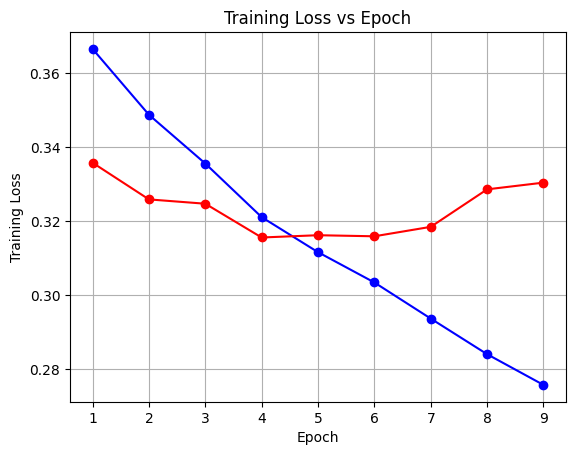

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', color='b')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, marker='o', color='r')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epoch')
plt.grid(True)
plt.show()

### Run Prediction on Validation Dataset

#### Run Predictions on Validation Set

##### Validation Loss

In [ ]:
## -- Set model to evaluation mode --
model.eval()

THRESHOLD_VAL = 0.1
predicted_rows = []

with torch.no_grad():
    for _X_tensor, _Y_tensor, film_ids_batch in tqdm(validation_dataloader):
         ## -- Move Tensors to device --
        _X_tensor = _X_tensor.to(device)
        _Y_tensor = _Y_tensor.to(device)

        ## -- Get Model Output --
        _model_output_logits = model(_X_tensor)
        _model_output = torch.sigmoid(_model_output_logits)                         # Apply Sigmoid [0, 1]

        ## -- Threshold Model Output --
        predicted_labels = (_model_output > THRESHOLD_VAL).int().cpu().numpy()

        # Loop through batch to collect rows
        for idx, film_id in enumerate(film_ids_batch):
            row = [film_id] + predicted_labels[idx].tolist()                        # [ID, genre_1, ..., genre_8]
            predicted_rows.append(row)

100%|██████████| 65/65 [00:00<00:00, 94.48it/s]


In [ ]:
column_names = ["film_id"] + FILM_CATEGORIES
validation_df_predictions = pd.DataFrame(predicted_rows, columns=column_names)

In [ ]:
validation_df_predictions.head()

,film_id,comedy,cult,flashback,historical,revenge,romantic,scifi,violence
0,d8b6bb0f-ae93-44ef-9396-480bf662a514,1,1,1,0,1,0,0,1
1,0c2f75f2-33a2-4264-b610-564016e7b92f,1,1,1,1,1,1,0,1
2,b71ed317-04cd-42f5-a380-d21dfea2bd36,1,0,1,1,0,1,0,0
3,e9c962fa-b631-4457-9fb1-381ea4dd3da7,0,1,1,0,1,0,0,1
4,751d7ccb-2600-4c6c-81a5-759b6f4d16bd,1,0,1,0,0,1,0,0


In [ ]:
assert len(validation_df_predictions) == len(validation_df)

##### Generate Validation Outputs

In [ ]:
# Please make sure that output format is like following (no header row, no title and plot columns):
# 94834c61-0e30-4799-9998-6f74f6sbb204	0	1	0	0	1	0	0	0
# 559sdd28-b6a2-4662-ab55-a6678as26a56	0	0	0	0	0	0	1	0
# b71y3317-04cd-42f5-a380-d21dfasdbd36	0	0	0	0	1	0	0	0

validation_df_predictions.to_csv(VALIDATION_SET_OUTPUT, header=False, index=False)

## End of your code cells

### Evaluation scripts

In [ ]:
def read_data(submission_file_path, gold_standard_file_path):
    """
    Read submission and gold standard files.
    Extract student ID from filename.
    """
    # Try to find student ID from the filename (looks for 8 digit numbers)
    id_regex = r'\d{8}'

    user_id = re.findall(id_regex, submission_file_path)
    print("Found your ID: ", user_id)
    if user_id:
        user_id = user_id[0]
    else:
        user_id = 'Unknown'

    # Load submission CSV
    print(f"\nLoading submission file: {submission_file_path}")
    submission_df = pd.read_csv(submission_file_path, sep=',', header=None,
                                quoting=csv.QUOTE_NONE, encoding='utf-8')

    # Load gold standard CSV
    print(f"Loading gold standard file: {gold_standard_file_path}")
    gold_standard_df = pd.read_csv(gold_standard_file_path, header=None)

    # Remove columns 1 and 2 (keep only ID and labels)
    gold_standard_df = gold_standard_df.drop([1, 2], axis=1)
    # Skip header row
    gold_standard_df = gold_standard_df.iloc[1:]

    return submission_df, gold_standard_df, user_id


def match_and_prepare_data(submission_df, gold_standard_df, user_id):
    """
    Match submission rows with gold standard rows by ID.
    Prepare data for evaluation.
    """
    gold_standard_labels = []
    submission_labels = []
    missed_rows = []
    submission_df_copy = submission_df.copy()

    print(f"\nMatching submission with gold standard...")
    print(f"Gold standard rows: {len(gold_standard_df)}")
    print(f"Submission rows: {len(submission_df_copy)}")

    # Match each gold standard row with submission
    for index, row in gold_standard_df.iterrows():
        row = row.reset_index(drop=True)
        row_found = False
        row_id = row[0]

        # Extract gold standard labels
        row_labels = [int(row[i]) for i in range(1, len(row))]
        gold_standard_labels.append(row_labels)

        # Find corresponding submission row
        for sub_index, submission_row in submission_df_copy.iterrows():
            if submission_row[0].strip() == row_id.strip():
                try:
                    # Extract submission labels
                    submission_row_labels = [int(submission_row[i]) for i in range(1, len(submission_row))]
                except:
                    # Handle malformed labels (take first character if multi-digit)
                    submission_row_labels = [int(str(submission_row[i])[0]) for i in range(1, len(submission_row))]

                submission_labels.append(submission_row_labels)
                row_found = True
                submission_df_copy.drop(sub_index, inplace=True)
                break

        if not row_found:
            # If row is missing, add inverse labels (worst possible prediction)
            missed_rows.append(row_id)
            submission_labels.append([0 if label == 1 else 1 for label in row_labels])

    return gold_standard_labels, submission_labels, missed_rows


def evaluate_submission(gold_standard_labels, submission_labels):
    """
    Calculate weighted F1 score.
    """
    print(f"\nCalculating weighted F1 score...")

    # Calculate weighted F1 score (accounts for class imbalance)
    f1_weighted = f1_score(gold_standard_labels, submission_labels, average='weighted')

    return f1_weighted


def print_results(user_id, f1_weighted, missed_rows):
    """
    Print evaluation results to screen.
    """
    print("\n" + "="*70)
    print("YOUR SUBMISSION EVALUATION REPORT")
    print("="*70)

    # Alert if ID not found in filename
    if user_id == 'Unknown':
        print('WARNING: ID not found in filename!')
        print('   Please ensure your filename contains your 8-digit student ID.')
        print()

    print(f"Your ID: {user_id}")
    print()

    # Display F1 score with visual indicator
    print("EVALUATION RESULTS:")
    print(f"   Weighted F1 Score: {f1_weighted:.4f}")
    print()

    # Report missing rows
    if missed_rows:
        print(f"MISSING DATA ({len(missed_rows)} rows not found):")
        print("-" * 70)
        for i, row in enumerate(missed_rows[:10], 1):  # Show first 10
            print(f"    {i}. Row ID: {row}")
        if len(missed_rows) > 10:
            print(f"    ... and {len(missed_rows) - 10} more missing rows")
        print()
        print("TIP: Make sure your submission includes all required rows.")
        print("        Missing rows are penalized with worst possible predictions.")
    else:
        print("DATA COMPLETENESS: All expected rows found in your submission!")

    print()
    print("="*70)
    print()


def evaluate(submission_path, gold_standard_path):
    """
    Main function to run the submission evaluation script.
    """

    submission_file = submission_path
    gold_standard_file = gold_standard_path

    # Check if files exist
    if not os.path.exists(submission_file):
        print(f"Error: Your submission file '{submission_file}' not found!")
        print("Make sure the file path is correct and the file exists.")
        sys.exit(1)

    if not os.path.exists(gold_standard_file):
        print(f"Error: Gold standard file '{gold_standard_file}' not found!")
        print("Make sure you have the correct gold standard file.")
        sys.exit(1)

    try:
        # Step 1: Read data
        submission_df, gold_standard_df, user_id = read_data(submission_file, gold_standard_file)

        # Step 2: Match and prepare data
        gold_standard_labels, submission_labels, missed_rows = match_and_prepare_data(
            submission_df, gold_standard_df, user_id
        )

        # Step 3: Evaluate
        f1_weighted = evaluate_submission(gold_standard_labels, submission_labels)

        # Step 4: Print results
        print_results(user_id, f1_weighted, missed_rows)

    except Exception as e:
        print(f"Error during evaluation: {str(e)}")
        print("Please check that your files are in the correct CSV format.")
        print("Each row should contain: ID, label1, label2, label3, ...")
        import traceback
        traceback.print_exc()
        sys.exit(1)

### Evaluate the model on the validation dataset

In [ ]:
# Please run the evaluation scripts cell above before running the mark_and_record

# Please make sure that output format is like following (no header row, no title and plot columns):
# 94834c61-0e30-4799-9998-6f74f6sbb204	0	1	0	0	1	0	0	0
# 559sdd28-b6a2-4662-ab55-a6678as26a56	0	0	0	0	0	0	1	0
# b71y3317-04cd-42f5-a380-d21dfasdbd36	0	0	0	0	1	0	0	0

evaluation_results = evaluate(VALIDATION_SET_OUTPUT, VALIDATION_SET)

Found your ID:  ['11372282']

Loading submission file: /content/drive/MyDrive/NLP_C2/data/11372282_CW2_task1_validation_results.csv
Loading gold standard file: /content/drive/MyDrive/NLP_C2/data/CW2_validation_dataset.csv

Matching submission with gold standard...
Gold standard rows: 1031
Submission rows: 1031

Calculating weighted F1 score...

YOUR SUBMISSION EVALUATION REPORT
Your ID: 11372282

EVALUATION RESULTS:
   Weighted F1 Score: 0.5027

DATA COMPLETENESS: All expected rows found in your submission!




In [ ]:
## NOTE: REMOVE BEFORE SUBMISSION!
sys.exit()

SystemExit: 

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Save predictions to formatted file.

In [ ]:
# Now please modify the code to format your output csv file.

# Please make sure that output format is like following (no header row, no tilte and plot columns):
# 94834c61-0e30-4799-9998-6f74f6sbb204	0	1	0	0	1	0	0	0
# 559sdd28-b6a2-4662-ab55-a6678as26a56	0	0	0	0	0	0	1	0
# b71y3317-04cd-42f5-a380-d21dfasdbd36	0	0	0	0	1	0	0	0

output_df = None  # Replace with your actual DataFrame or output
# For example, if you have a DataFrame named 'output_df', you can save it
assert isinstance(output_df, pd.DataFrame)
assert len(output_df) == NUM_ROWS_TEST, "Output length is not aligned with the testdata.csv."
assert len(output_df.columns) == 9, "Please make sure to follow the format above and keep only IDs and 8 columns of prediction."
output_df.to_csv(f'./{STUDENT_ID}_CW2_task1_results.csv', index=False, header=False)